In [115]:
from pandas import read_csv, concat, DataFrame
from seaborn import FacetGrid, lineplot, move_legend
from matplotlib import pyplot as plt

import matplotlib.ticker as ticker
import squarify
import numpy as np

In [121]:
""" Helper functions (plotting)
"""

def line_scaled(*args, scale=1, **kwargs):
    ax = lineplot(x=args[0], y=args[1], **kwargs)
    
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale))
    ax.yaxis.set_major_formatter(ticks_y)
    


# The Data
## Overview

2.

(2a)
* What sources - brief description, give some headline assumptions
  * UNPD
  * GBD
  * Earth4All
(2b)
* Scenarios we're focusing on, maybe a plot in here with headline assumptions
  * UNPD: High, Med, Low
  * GBD: Reference, SDG Met Need
  * Earth4All: Too Little Too Late, Giant Leap

## Initial look at the data
3.
(3a)
* Methodology
  * Multiple ways to pull data from UNPD, API or catalogue of downloads, downloading csv simpler for exploratory work (haven't decided what we're looking for) but for specific datasets I've got some simple bits of python to wrap the API and pull in specific datasets
  * At least for UNPD (picture is a little more complex for other forecasts) most of the useful/interesting metrics are either in the data or a relatively simple calculation
  * One big project-specific question is "when are the Next 8 Billion born?"
  * Set methodology here.
  * Note that not all forecasts have a next 8 bn this century - suggest one could do a simple extrapolation but this overlooks the complexity of the forecasts and all the assumptions that will be broken in doing this.
* When do we reach 8 Billion?
  * Plot of cumulative births since 2023
  * Maybe add (faint) lines for specific forecasts?
  * Plot all births as well, make it a births-focused section
* Population stats
  * Total population
  * Median age
  * Dependency ratio
  * Do all of above grouped by income groups
  * G20, P20
  
# Dave wrap up

In [116]:
""" Load all data here """
""
datapaths = [ # load these iteratively
    "../../data/prepared_data/gbd_world_births.csv",
    "../../data/prepared_data/unpd_world_indicators.csv",
    "../../data/prepared_data/cumulative_births_unpd_all_countries.csv",
    "../../data/prepared_data/e4a_combined_labelled.csv"
]

df_gbd_births, df_unpd_world, df_unpd_cumul, df_e4a = [
    read_csv(dpath) for dpath in datapaths
]

# bigger datasets (need to unset low mem opt.) - del these from mem when out of scope
df_all_locs = concat(
    [
        read_csv("../../data/unpd_data/WPP2022_Demographic_Indicators_Medium.csv", low_memory=False),
        read_csv("../../data/unpd_data/WPP2022_Demographic_Indicators_OtherVariants.csv", low_memory=False)
    ])

metadata = read_csv("../../data/metadata/UNSD — Methodology.csv", delimiter=";")

n8b = read_csv("../../data/prepared_data/date_for_8bn.csv").loc[:,["scenario_name","year_id"]]

In [216]:
# large data load here
df_unpd_large = read_csv("../../data/prepared_data/unpd_large.csv", low_memory=False)
df_dependecy_r = read_csv("../../data/prepared_data/dependency_ratios.csv", low_memory=False)

In [117]:
n8b

,scenario_name,year_id
0,High,2068.0
1,Low,NaN
2,Medium,2083.0
3,Reference,2095.0
4,SDG Met Need and Education,NaN


In [71]:
df_combined_global = concat(
    [df_unpd_world,
    df_gbd_births.loc[:,["val","year_id","scenario_name"]].rename(columns={
        "val": "BirthsSingle",
        "year_id": "Time",
        "scenario_name": "Variant"}),
    df_e4a.loc[:,["Births","scenario","year_id"]].rename(columns={
        "Births": "BirthsSingle",
        "year_id": "Time",
        "scenario": "Variant"})
    ]).reset_index()

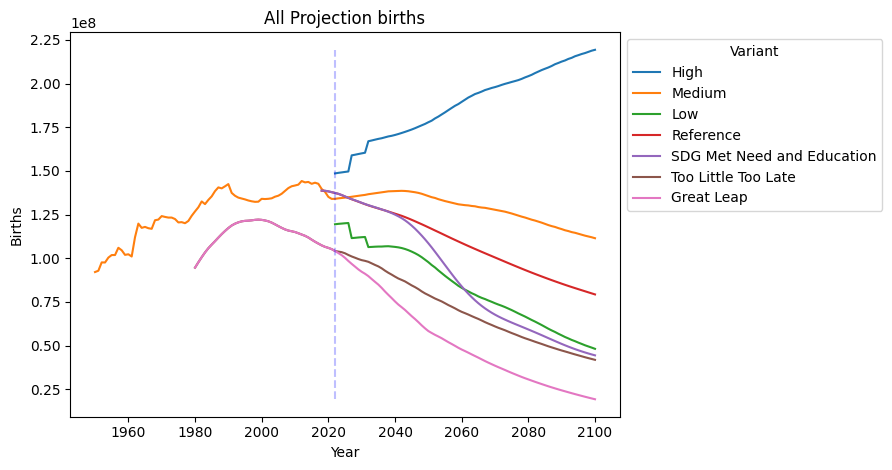

In [91]:
df_combined_global

ax = lineplot(data=df_combined_global,
              x="Time",
              y="BirthsSingle",
              hue="Variant",
              hue_order=["High",
                        "Medium",
                        "Low",
                        "Reference",
                        "SDG Met Need and Education",
                        "Too Little Too Late",
                        "Great Leap"])
plt.title("All Projection births")
plt.xlabel("Year")
plt.ylabel("Births")
plt.vlines(2022,
           df_combined_global.BirthsSingle.min(),
           df_combined_global.BirthsSingle.max(),
           color="b",linestyle="dashed", alpha=0.25)
plt.tight_layout()
move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

## Birth projections

* All forecasts compared to each other
* Clustering together seen from Great Leap to UN Medium (or arguably GBD Reference)
* Note difference in estimation of previous births TODO: find compelling reason for difference in past estimates
* TODO: check assumptions and give good reasons for differences in forecasts (explain High forecast, give an idea of why med in that place and then discuss why lower forecasts so much lower)

In [75]:
cumulative_births_comb = df_combined_global[df_combined_global.Time > 2022]\
    .sort_values(["Variant","Time"], ascending=True)\
    .set_index(["Variant","Time"])\
    .groupby("Variant")\
    .BirthsSingle\
    .cumsum()\
    .reset_index()

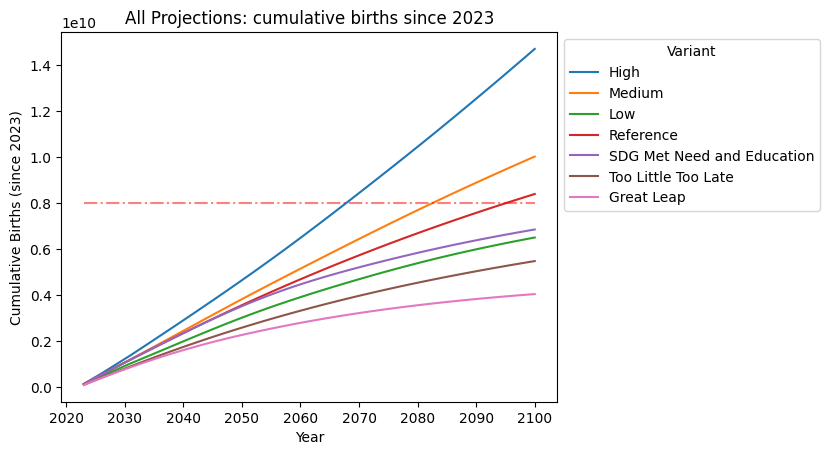

In [82]:
ax = lineplot(data=cumulative_births_comb,
             x="Time",
             y="BirthsSingle",
             hue="Variant",
             hue_order=["High",
                        "Medium",
                        "Low",
                        "Reference",
                        "SDG Met Need and Education",
                        "Too Little Too Late",
                        "Great Leap"]
             )
plt.title("All Projections: cumulative births since 2023")
plt.xlabel("Year")
plt.ylabel("Cumulative Births (since 2023)")
plt.hlines(8e9, 2023, 2100, color="r",linestyle="dashdot", alpha=0.5)
move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

Cumulative births

* Counting births from 2023
* Area under curve from previous plot
* 

In [185]:
# start with regional level data
df_regional = df_unpd_large[df_unpd_large.Type=="Region"]

df_regional.loc[:,"Region, subregion, country or area *"] = df_regional["Region, subregion, country or area *"].apply(lambda w: w.capitalize())
df_regional.loc[:,"Births (thousands)"] = df_regional["Births (thousands)"].apply(float)
df_regional.loc[:,"Births (single)"] = df_regional["Births (thousands)"].apply(lambda b: int(b*1_000))
df_regional.loc[:,"Median Age, as of 1 July (years)"] = df_regional["Median Age, as of 1 July (years)"].apply(float)
df_regional.loc[:,"Life Expectancy at Birth, both sexes (years)"] = df_regional["Life Expectancy at Birth, both sexes (years)"].apply(float)

/tmp/ipykernel_27988/3997060709.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_regional.loc[:,"Births (single)"] = df_regional["Births (thousands)"].apply(lambda b: int(b*1_000))


In [203]:
# Then prep income group
df_income = df_unpd_large[df_unpd_large.Type=="Income Group"]

df_income = df_income.loc[df_income["Region, subregion, country or area *"] != "No income group available"]
df_income.loc[:,"Births (thousands)"] = df_income["Births (thousands)"].apply(float)
df_income.loc[:,"Births (single)"] = df_income["Births (thousands)"].apply(lambda b: int(b*1_000))
df_income.loc[:,"Median Age, as of 1 July (years)"] = df_income["Median Age, as of 1 July (years)"].apply(float)
df_income.loc[:,"Life Expectancy at Birth, both sexes (years)"] = df_income["Life Expectancy at Birth, both sexes (years)"].apply(float)

In [225]:
df_dependecy_r = df_dependecy_r[df_dependecy_r.Year.notna()]
df_dependecy_r.loc[:,"Year"] = df_dependecy_r.loc[:,"Year"].apply(int)
df_dependecy_r.loc[:,"Annual total dep. ratio [(0-14 & 65+) / 15-64] (%)"] = df_dependecy_r.loc[:,"Annual total dep. ratio [(0-14 & 65+) / 15-64] (%)"].apply(float)
df_dep_region = df_dependecy_r[df_dependecy_r.Type=="Region"]
df_dep_income = df_dependecy_r[df_dependecy_r.Type=="Income Group"]
df_dep_region.loc[:,"Region, subregion, country or area *"] = df_dep_region["Region, subregion, country or area *"].apply(lambda w: w.capitalize())

In [169]:
def plot_n8b_points(col1, col2, label, n8b=n8b, *args, **kwargs):
    """ Helper function for plotting n8b points from data """
    df = DataFrame({"time":col1, "data": col2, "label": [label]*len(col1)})
    points = df.merge(n8b,
            "right",
            left_on=["time", "label"],
            right_on=["year_id","scenario_name"])
    plt.plot(points.time, points.data, "rx")

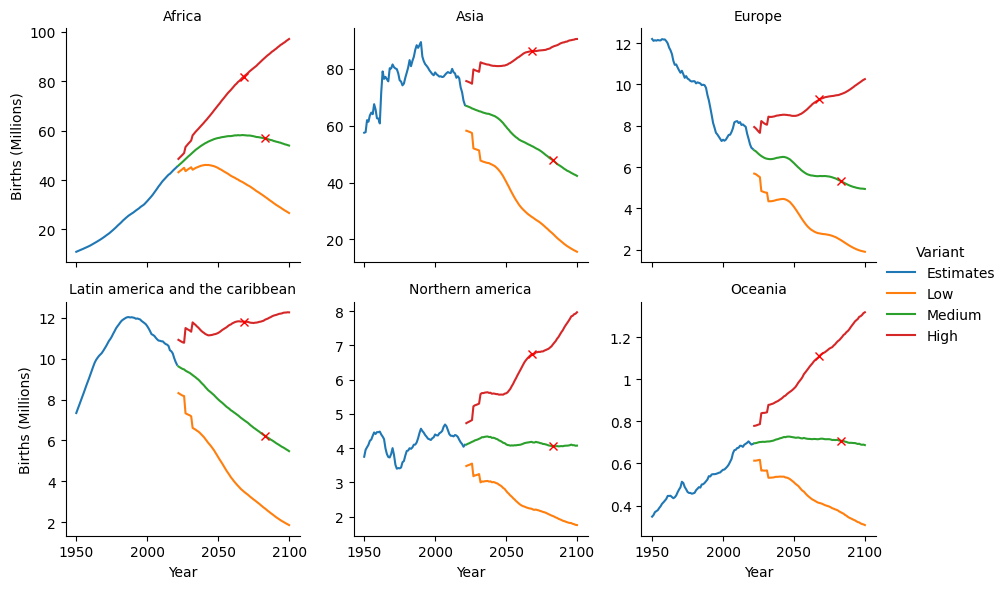

In [170]:
f = FacetGrid(data=df_regional,
                  col="Region, subregion, country or area *",
                  hue="Variant",
                  col_wrap=3,
                  sharex=True,
                  sharey=False)
f.map(line_scaled, "Year", "Births (thousands)", scale=1e3)
f.map(plot_n8b_points, "Year", "Births (thousands)")
f.set_titles("{col_name}")
f.add_legend()
f.set_ylabels("Births (Millions)")
plt.show()

* Europe shows dramatic drop in births over time
* Differences between birth scenarios Low to High dramatic across all forecasts
* Even Medium scenario predominantly births dropping (though flatter in N. America and Oceania)

In [171]:
cumulative_births_region = df_regional[df_regional.Year > 2022]\
    .sort_values(["Region, subregion, country or area *","Variant","Year"], ascending=True)\
    .set_index(["Region, subregion, country or area *","Variant","Year"])\
    .groupby(["Region, subregion, country or area *","Variant"])["Births (single)"]\
    .cumsum()\
    .reset_index()

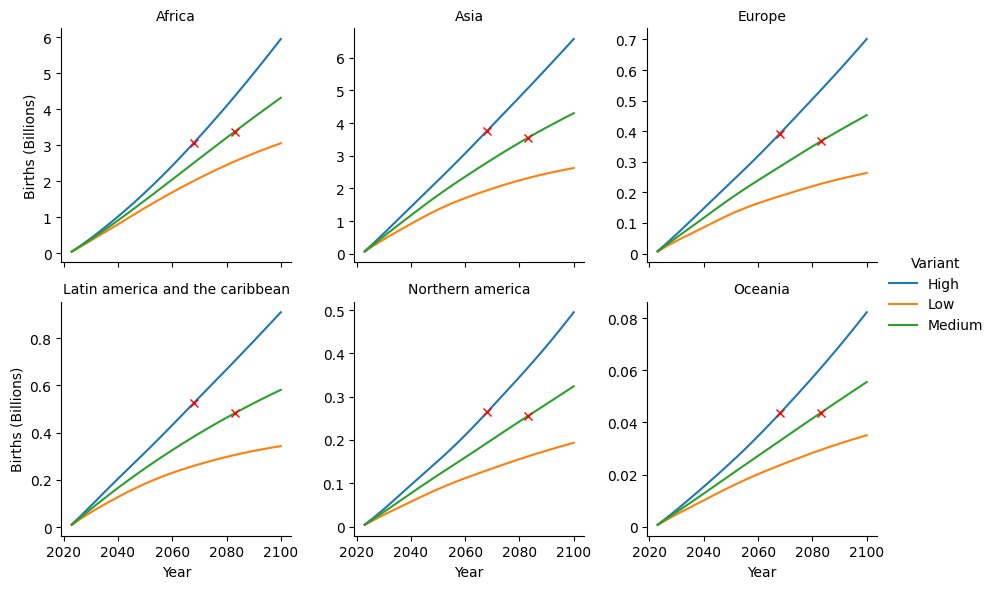

In [172]:
f = FacetGrid(data=cumulative_births_region,
              col="Region, subregion, country or area *",
              col_wrap=3,
              hue="Variant",
              sharex=True,
              sharey=False)
f.map(line_scaled, "Year", "Births (single)", scale=1e9)
f.map(plot_n8b_points, "Year", "Births (single)")
f.set_titles("{col_name}")
f.add_legend()
f.set_ylabels("Births (Billions)")

Note figures around N8B points: First two regions domainate the next 8 billion

## Population statistics 

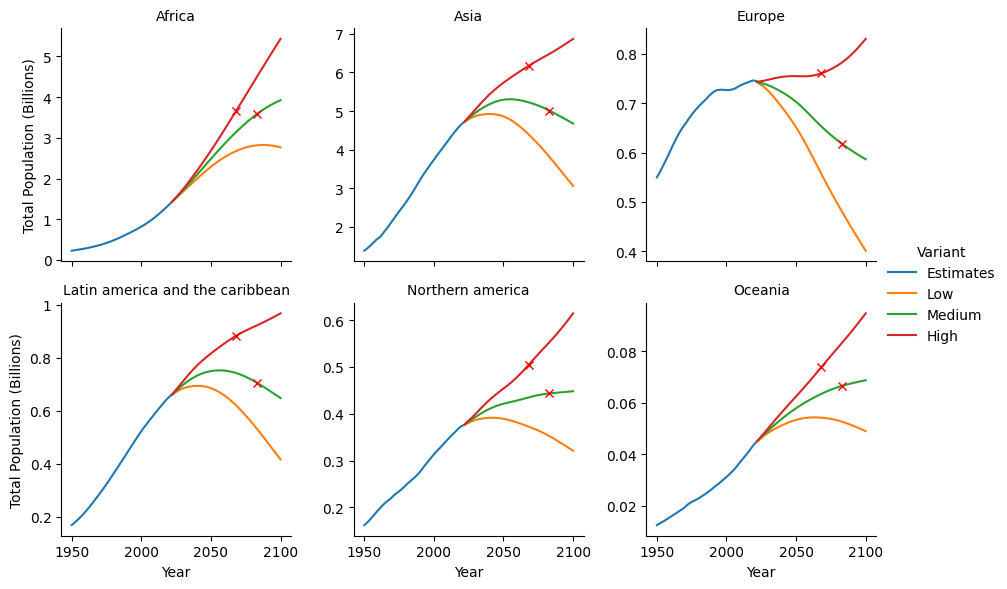

In [173]:
f = FacetGrid(data=df_regional,
                  col="Region, subregion, country or area *",
                  hue="Variant",
                  col_wrap=3,
                  sharex=True,
                  sharey=False)
f.map(line_scaled, "Year", "Total Population (Billions)",)
f.map(plot_n8b_points, "Year", "Total Population (Billions)")
f.set_titles("{col_name}")
f.add_legend()

## Population per region

Some observations
* Some dramatic drops in growth for Low scenario (esp. Europe)
* Significant variation in what Medium scenario means for population growth 

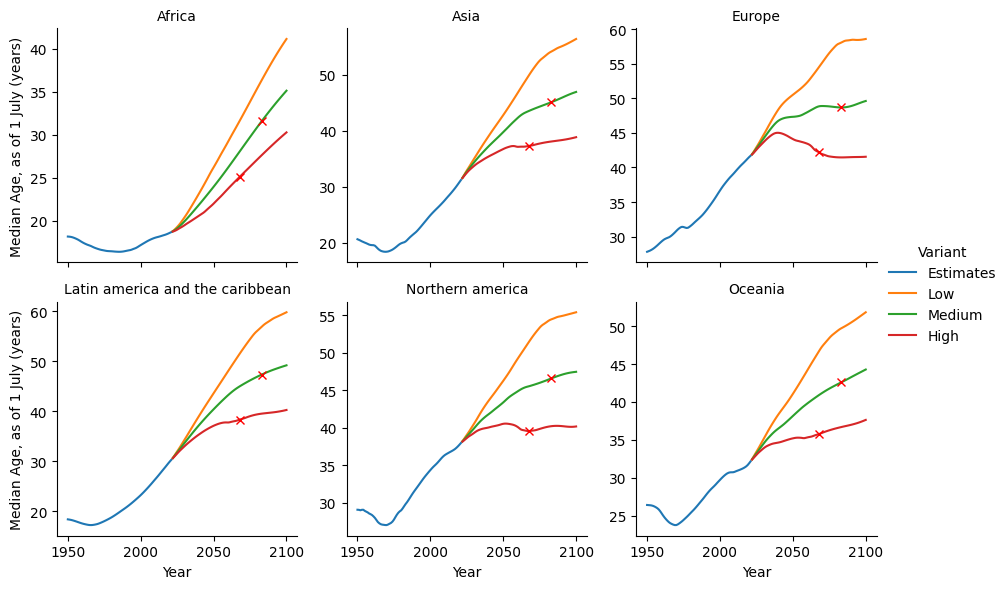

In [182]:
f = FacetGrid(data=df_regional,
                  col="Region, subregion, country or area *",
                  hue="Variant",
                  col_wrap=3,
                  sharex=True,
                  sharey=False)
f.map(lineplot, "Year", "Median Age, as of 1 July (years)",)
f.map(plot_n8b_points, "Year", "Median Age, as of 1 July (years)")
f.set_titles("{col_name}")
f.add_legend()

* Note sharp rises up to high values in Low scenarios
* Latin America/Caribbean and Europe highest median ages, around 60 by end of C
* Rises in all scenarios 
* To a degree explained by life expectancy

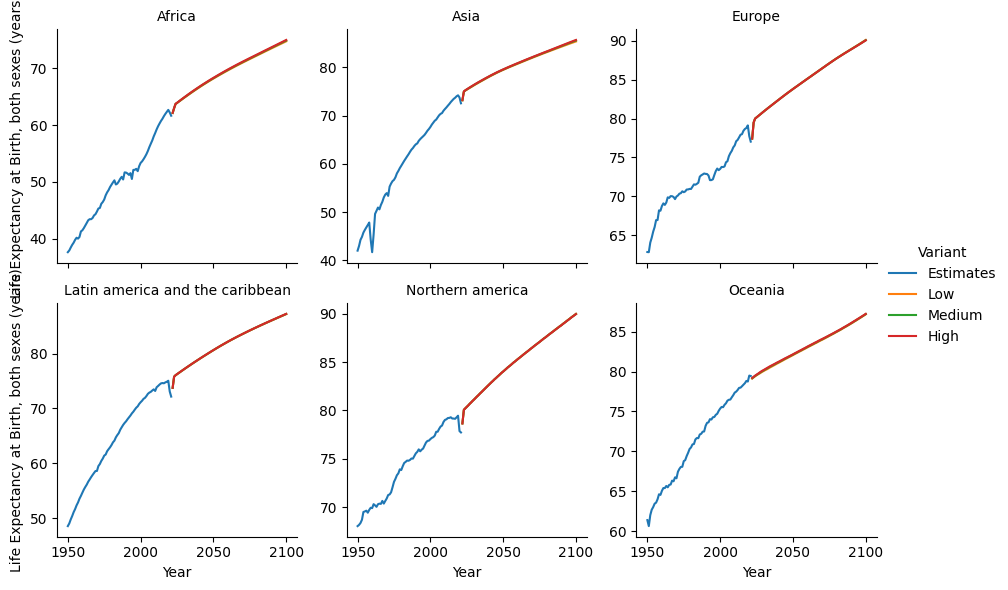

In [186]:
f = FacetGrid(data=df_regional,
                  col="Region, subregion, country or area *",
                  hue="Variant",
                  col_wrap=3,
                  sharex=True,
                  sharey=False)
f.map(lineplot, "Year", "Life Expectancy at Birth, both sexes (years)",)
f.set_titles("{col_name}")
f.add_legend()

Note very minimal change between forecasts - leading to consistently high impact. Principal reason for this is that the scenario assumptions for Low, Medium, High leave life expectancy/mortality intact.

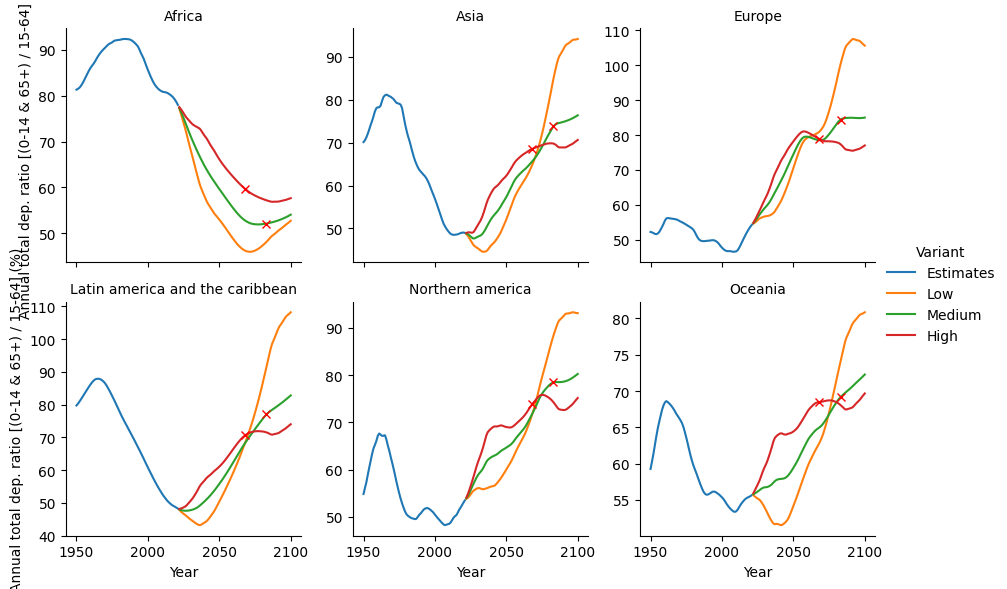

In [227]:
f = FacetGrid(data=df_dep_region,
                  col="Region, subregion, country or area *",
                  hue="Variant",
                  col_wrap=3,
                  sharex=True,
                  sharey=False)
f.map(lineplot, "Year", "Annual total dep. ratio [(0-14 & 65+) / 15-64] (%)")
f.map(plot_n8b_points, "Year", "Annual total dep. ratio [(0-14 & 65+) / 15-64] (%)")
f.set_titles("{col_name}")
f.add_legend()

## Income groups

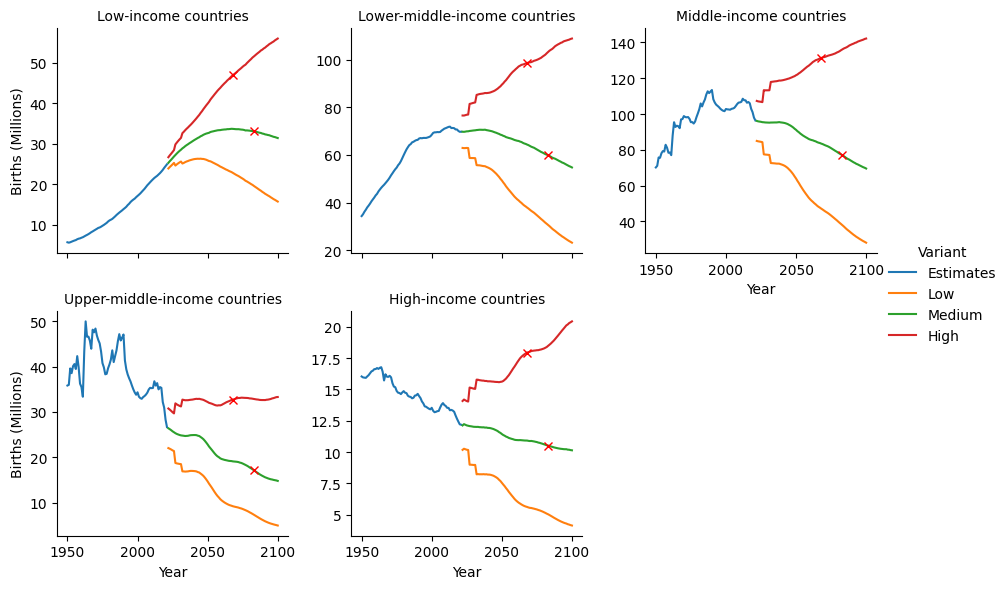

In [212]:
f = FacetGrid(data=df_income,
                  col="Region, subregion, country or area *",
                  hue="Variant",
                  col_wrap=3,
                  sharex=True,
                  sharey=False,
                  col_order=["Low-income countries",
                             "Lower-middle-income countries",
                             "Middle-income countries",
                             "Upper-middle-income countries", 
                             "High-income countries"])
f.map(line_scaled, "Year", "Births (thousands)", scale=1e3)
f.map(plot_n8b_points, "Year", "Births (thousands)")
f.set_titles("{col_name}")
f.add_legend()
f.set_ylabels("Births (Millions)")
plt.show()

In [205]:
cumulative_births_income = df_income[df_income.Year > 2022]\
    .sort_values(["Region, subregion, country or area *","Variant","Year"], ascending=True)\
    .set_index(["Region, subregion, country or area *","Variant","Year"])\
    .groupby(["Region, subregion, country or area *","Variant"])["Births (single)"]\
    .cumsum()\
    .reset_index()

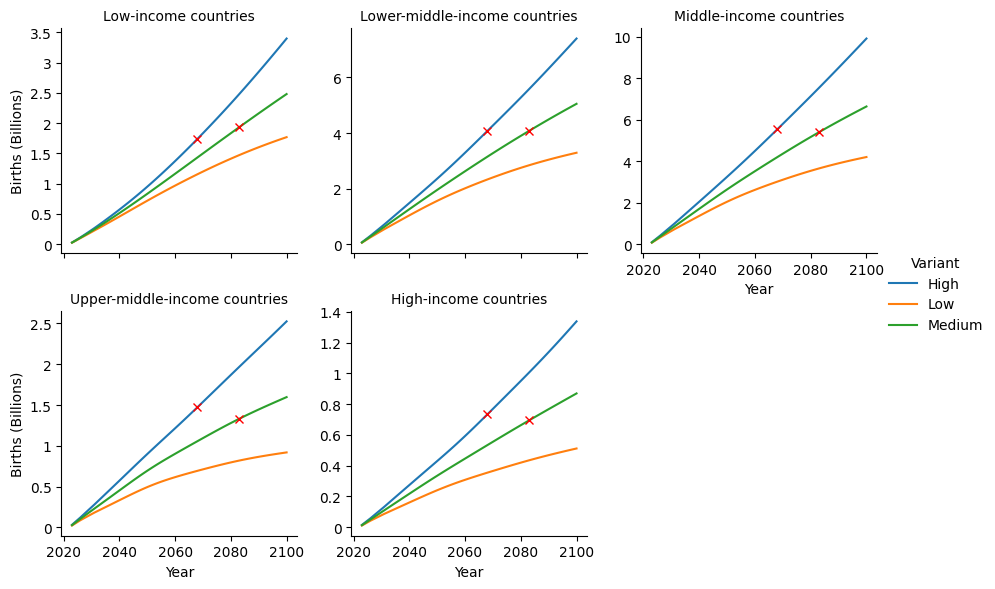

In [213]:
f = FacetGrid(data=cumulative_births_income,
              col="Region, subregion, country or area *",
              col_wrap=3,
              hue="Variant",
              sharex=True,
              sharey=False,
                  col_order=["Low-income countries",
                             "Lower-middle-income countries",
                             "Middle-income countries",
                             "Upper-middle-income countries", 
                             "High-income countries"])
f.map(line_scaled, "Year", "Births (single)", scale=1e9)
f.map(plot_n8b_points, "Year", "Births (single)")
f.set_titles("{col_name}")
f.add_legend()
f.set_ylabels("Births (Billions)")

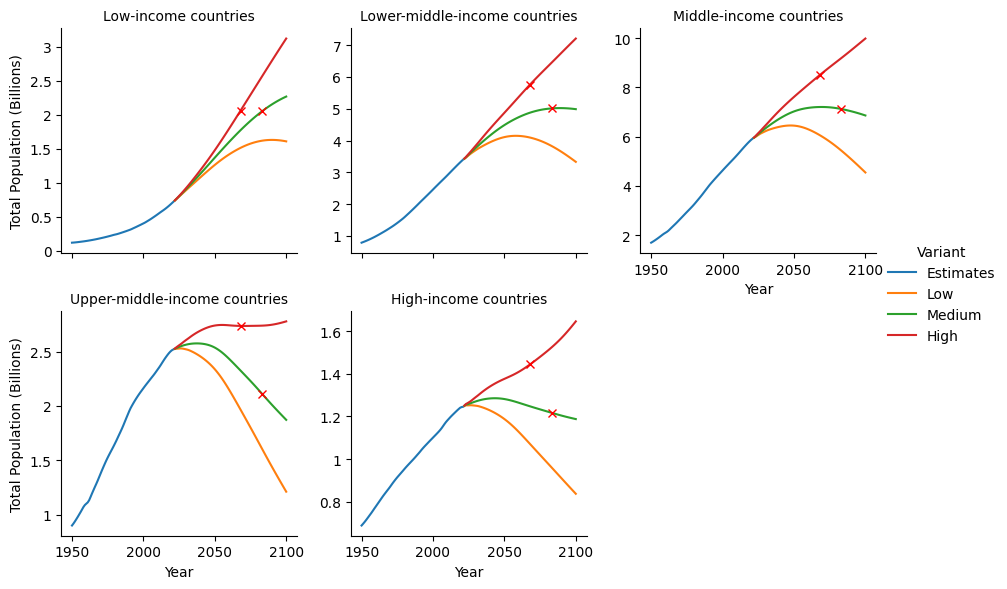

In [214]:
f = FacetGrid(data=df_income,
                  col="Region, subregion, country or area *",
                  hue="Variant",
                  col_wrap=3,
                  sharex=True,
                  sharey=False,
                  col_order=["Low-income countries",
                             "Lower-middle-income countries",
                             "Middle-income countries",
                             "Upper-middle-income countries", 
                             "High-income countries"])
f.map(line_scaled, "Year", "Total Population (Billions)",)
f.map(plot_n8b_points, "Year", "Total Population (Billions)")
f.set_titles("{col_name}")
f.add_legend()

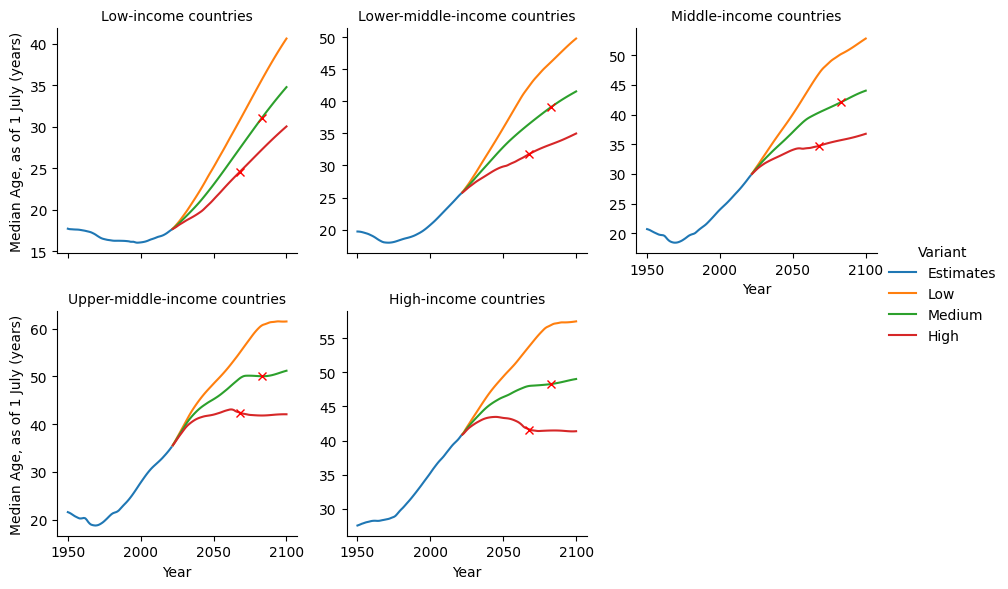

In [215]:
f = FacetGrid(data=df_income,
                  col="Region, subregion, country or area *",
                  hue="Variant",
                  col_wrap=3,
                  sharex=True,
                  sharey=False,
                  col_order=["Low-income countries",
                             "Lower-middle-income countries",
                             "Middle-income countries",
                             "Upper-middle-income countries", 
                             "High-income countries"])
f.map(lineplot, "Year", "Median Age, as of 1 July (years)",)
f.map(plot_n8b_points, "Year", "Median Age, as of 1 July (years)")
f.set_titles("{col_name}")
f.add_legend()

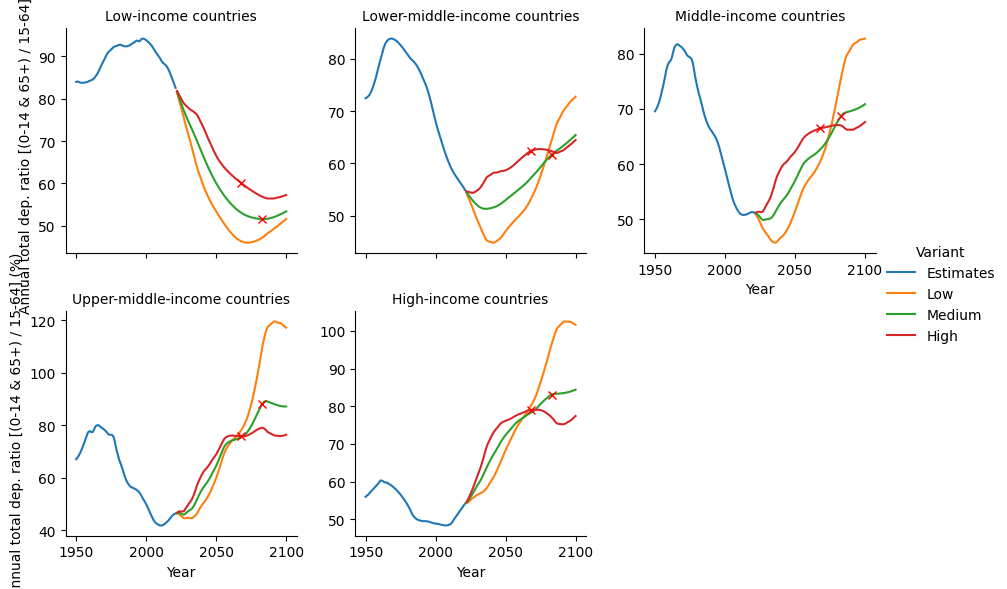

In [229]:
f = FacetGrid(data=df_dep_income,
                  col="Region, subregion, country or area *",
                  hue="Variant",
                  col_wrap=3,
                  sharex=True,
                  sharey=False,
                  col_order=["Low-income countries",
                             "Lower-middle-income countries",
                             "Middle-income countries",
                             "Upper-middle-income countries", 
                             "High-income countries"])
f.map(lineplot, "Year", "Annual total dep. ratio [(0-14 & 65+) / 15-64] (%)")
f.map(plot_n8b_points, "Year", "Annual total dep. ratio [(0-14 & 65+) / 15-64] (%)")
f.set_titles("{col_name}")
f.add_legend()